In [1]:
import pickle
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from human_hip.raw_data import get_brain_waves, cwt_spectrogram, spectrogram_plot, butter_filter
from human_hip.spike_data import read_autocurated_data, plot_raster
import numpy as np
from scipy.ndimage import gaussian_filter1d

from scipy.signal import hilbert, correlate, find_peaks
from astropy.stats import rayleightest, circmean, circstd

# Packages for plotting spectrogram
from scipy import ndimage
from matplotlib.colors import LogNorm #Normalize
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pickle 
from human_hip.histology import plot_histology, plot_histology_electrode_map
from human_hip.spike_data import read_phy_files, read_autocurated_data

import os
from sklearn.cluster import KMeans
import pandas as pd

# !pip install statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [9]:
# # set parameters

# # Main recording
# S_SB_TIMES = [
#             [9, 28],
#             [38, 52],
#             [69, 83],
#             [100, 113],
#             [138, 151],
#             [176, 187],
#             [211, 220],
#             [246, 254]
#             ]

# NS_SB_TIMES = [
#             [28, 38],
#             [54, 66],
#             [85, 97],
#             [115, 127],
#             [155, 167],
#             [193, 205],
#             [228, 240],
#             [260, 272]
#             ]



# SPIKE_PATH = "human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip"
# LFP_PATH = "human_hippocampus/data/ephys_raw/2023-12-03-e-Hc112823_avv9hckcr1"


# Other seizure recording
S_SB_TIMES = [
            [0, 11],
            [25, 39],
            [139, 148],
            [168, 174],
            [258, 263],
            [320, 328],
            [481, 487],
            ]

NS_SB_TIMES = [
            [50, 60],
            [100, 113],
            [200, 212],
            [270, 275],
            [392, 400],
            [400, 406],
            [450, 455],
            ]

# # SPIKE_PATH = "human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_2.zip"
# SPIKE_PATH = "human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/derived/kilosort2/Hc120523_aav9hckcr1_chip21769_121123_2_acqm.zip"
LFP_PATH = "human_hippocampus/data/ephys_raw/2023-12-11-e-Hc120523_aav9hckcr1_chip21769"

# # # load spike data whole recording
# sd = read_autocurated_data( "/workspaces/" + SPIKE_PATH )
sd = read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_2.zip")



# LFP_PATH = "human_hippocampus/data/ephys_raw/2023-05-10-e-hc52_18790_unperturbed"

# S_SB_TIMES = [
#             [19, 29],
#             [50, 60],
#             [6, 16]
#             ]

# with open('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/5-10-23s1-CutData.pkl', 'rb' ) as my_file:
#     sd = pickle.load(my_file)

In [48]:
S_SB_TIMES
all_spk_angles[unit]

[]

In [10]:
# # # SPIKE PHASE LOCKING # # #

SIG_THRESH = 0.05
NUM_CLOSEST = 1
RMS_MULT = 1
PLOT_UNIT = 99999999 # used for plotting a temporary figure of single units, main figure code is 2 cells down

# # #

def find_k_closest_rows(arr1, arr2, k):
    distances = np.linalg.norm(arr1[:, np.newaxis] - arr2, axis=2)
    closest_indices = np.argsort(distances, axis=1)[:, :k]
    return closest_indices

# # #

def find_closest_values(array, target):
    # Filter the array into smaller and larger values
    smaller_values = np.array([x for x in array if x < target])
    larger_values = np.array([x for x in array if x > target])

    # Handle edge cases where no smaller or larger values exist
    if len(smaller_values) == 0:
        closest_smaller = None
    else:
        # Find the index of the closest smaller value
        closest_smaller_index = np.abs(smaller_values - target).argmin()
        closest_smaller = smaller_values[closest_smaller_index]

    if len(larger_values) == 0:
        closest_larger = None
    else:
        # Find the index of the closest larger value
        closest_larger_index = np.abs(larger_values - target).argmin()
        closest_larger = larger_values[closest_larger_index]

    return closest_smaller, closest_larger

# # #

def plot_polar_hist(radian_values, nbins=16, bar_color="b"):
    
    # Initiate a figure with polar axis
    ax = plt.subplot(111, polar=True)

    # bin the radian values
    counts, bin_edges = np.histogram(radian_values, bins=nbins, range=(-np.pi, np.pi))
    bin_centers = bin_edges[:-1] + 0.5*np.diff(bin_edges)

    # plot bin results as a barplot on polar axis
    ax.bar(bin_centers, counts, color=bar_color, width=np.diff(bin_edges), bottom=0.0)

    plt.show()
    return

# # #

def plot_phase_lock_sig(spk_times, av_nearby_theta, all_nearby_theta, x_lim=None):

    # Initiate figure
    plt.figure(figsize=(10, 4))

    # plot average signal
    plt.plot(range(len(av_nearby_theta)), av_nearby_theta, "k", linewidth=2)

    # if av_nearby_theta is averaged over more than one electrode
    if all_nearby_theta.shape[0] > 1:

        # for each averaged electrode
        for i in range(all_nearby_theta.shape[0]):

            # plot signal
            plt.plot(range(len(av_nearby_theta)), all_nearby_theta[i,:]/2+(i+1)*10, "b", linewidth=1)

    # for each spike
    for spk in spk_times:

        plt.scatter(spk, av_nearby_theta[spk], s=50, c="r")
    
    if x_lim == None:
        plt.xlim([0,len(av_nearby_theta)])
    else:
        plt.xlim(x_lim)

    plt.xticks([])
    plt.yticks([])

    plt.show()
    return

# # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# initiate empty result libraries
all_spk_angles = {}
all_spk_times = {}

# for each superburst
for i, sb in enumerate(S_SB_TIMES):
    print(sb)

    # load LFP data
    # with open("/workspaces/" + LFP_PATH + "/acid1_start{}s_stop{}s_fs1ms.pkl".format(sb[0], sb[1]), 'rb') as filename:
    with open("/workspaces/" + LFP_PATH + "/seizure/acid1_start{}s_stop{}s_fs1ms.pkl".format(sb[0], sb[1]), 'rb') as filename:
        data_raw = pickle.load(filename)

    # filter LFP data into individual theta frequency band
    theta_filt = butter_filter(data_raw["data"], 4, 8, fs=data_raw["frame_rate"])

    # if this is the first iteration of the loop
    if i == 0:

        # obtain electrode coordinates
        elec_xy = data_raw["xy"].copy()
        elec_xy[:,1] = data_raw["xy"][:,0]/12.5
        elec_xy[:,0] = data_raw["xy"][:,1]

        # obtain unit locations
        unit_xy = []
        for unit in sd.neuron_data[0].values():
            unit_xy.append([unit['position'][0], unit['position'][1]] )
        unit_xy = np.array(unit_xy)

        # find NUM_CLOSEST closest electrodes to each unit
        closest_elecs = find_k_closest_rows(unit_xy, elec_xy, NUM_CLOSEST)


    # for each unit
    for unit in range(len(sd.train)):

        # get spike times from sd
        spk_times= np.unique(np.round(sd.train[unit]).astype(int))

        # average the theta LFP over the closest electrodes
        av_nearby_theta = np.mean(theta_filt[closest_elecs[unit,:], :], axis=0) # 5400:6000
        av_raw_sig = np.mean(data_raw["data"][closest_elecs[unit,:], :], axis=0)
        # sb[1] = sb[0]+6
        # sb[0] = sb[0]+5.4

        # compute the envelope and phase angles of the averaged theta
        nearby_theta_hilbert = hilbert(av_nearby_theta)
        sig_env = np.abs(nearby_theta_hilbert)
        nearby_angles = np.angle(nearby_theta_hilbert)

        # compute sig_env RMS
        sig_env_rms = np.sqrt(np.mean(sig_env**2))

        # obtain all peaks above sig_env RMS
        detected_peaks, _ = find_peaks(av_nearby_theta, height=sig_env_rms*RMS_MULT)
        all_troughs, _ = find_peaks(-av_nearby_theta)

        # initiate empty result array
        if i == 0:
            all_spk_angles[unit] = []
            all_spk_times[unit] = []

        all_spk_times[unit] = np.append(all_spk_times[unit], spk_times[(spk_times > sb[0]*1000) & (spk_times < sb[1]*1000)])

        # for each detected peak
        for peak in detected_peaks:

            # find the trouhgs on each side of the peak
            pre_trough, post_trough = find_closest_values(all_troughs, peak)

            if pre_trough == None:
                pre_trough = 0
            if post_trough == None:
                post_trough = len(av_nearby_theta)

            # detect spike times within range
            cycle_spk_times = spk_times[(spk_times > sb[0]*1000+pre_trough) & (spk_times < sb[0]*1000+post_trough)]

            # obtain all spike time angles within cycle
            spk_angles_cycle = nearby_angles[cycle_spk_times-np.int32(sb[0]*1000)]

            # store all spikes in cycle
            all_spk_angles[unit] = np.append(all_spk_angles[unit], spk_angles_cycle)


        # if results should be plotted for this unit
        if unit == PLOT_UNIT and i == 0:

            # Initiate figure
            plt.figure(figsize=(10, 4))

            # plot average signal
            plt.plot(range(len(av_raw_sig)), av_raw_sig-np.mean(av_raw_sig), "k", linewidth=2)
            plt.plot(range(len(av_nearby_theta)), 3*av_nearby_theta-60, "b", linewidth=2)
            plt.plot(range(len(sig_env)), 3*sig_env-60, "r", linewidth=2)
            plt.plot(range(len(nearby_angles)), nearby_angles*3-100, "g", linewidth=2)

            plt.plot(range(len(sig_env)), 3*sig_env_rms*np.ones_like(sig_env)-60, "y--", linewidth=2)

            plt.scatter(sb_spk_times-sb[0]*1000, 3*av_nearby_theta[sb_spk_times-sb[0]*1000]-60, s=50, c="k")

            # plt.xlim(5000,10000)

            plt.show()


# initiate empty result array
rayleigh_p = np.empty((len(sd.train),))
rayleigh_p[:] = np.nan
mean_angle = np.empty((len(sd.train),))
mean_angle[:] = np.nan
num_spks = np.empty((len(sd.train),))
num_spks[:] = np.nan
total_num_spks = np.empty((len(sd.train),))
total_num_spks[:] = np.nan

# for each unit
for unit in range(len(sd.train)): 

    if len(all_spk_angles[unit])>0:
        # compute p-value of rayleigh test and store
        rayleigh_p[unit] = rayleightest(all_spk_angles[unit])
        mean_angle[unit] = circmean(all_spk_angles[unit])
    num_spks[unit] = len(all_spk_angles[unit])
    total_num_spks[unit] = len(all_spk_times[unit])


# find units with significant scores
sig_units = np.where(rayleigh_p<SIG_THRESH)

print(sig_units)
print(rayleigh_p[sig_units])
print(num_spks[sig_units])

# # define data save path given parameters
# data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_theta_spike_locking_s.pkl"
# data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-11-e-Hc120523_aav9hckcr1_chip21769_theta_spike_locking_s.pkl"

# # Save the data to a file
# with open(data_save_path, 'wb') as f:
#     pickle.dump({'rayleigh_p': rayleigh_p, 'mean_angle': mean_angle}, f) # , "unit_av_clus_id":unit_av_clus_id

# print("Results saved")

# rayleigh_p_s = rayleigh_p
# mean_angle_s = mean_angle
# num_spks_s = num_spks
# total_num_spks_s = total_num_spks


[0, 11]


/tmp/ipykernel_853/1921995070.py:119: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for unit in sd.neuron_data[0].values():


[25, 39]
[139, 148]
[168, 174]
[258, 263]
[320, 328]
[481, 487]
(array([  0,   1,   2,   3,   5,   8,   9,  10,  12,  13,  16,  17,  20,
        21,  24,  26,  27,  29,  30,  31,  33,  34,  35,  38,  39,  40,
        41,  42,  43,  44,  46,  47,  48,  50,  51,  54,  55,  56,  57,
        58,  60,  61,  63,  65,  66,  67,  69,  71,  72,  73,  74,  75,
        76,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        93,  94,  95,  96, 100, 101, 102, 104, 106, 107, 108, 111, 112,
       114, 116, 117, 118, 119, 123, 124, 131, 138, 139, 142, 145, 151,
       154, 156, 159, 160, 166, 167, 168, 175, 177, 178]),)
[5.72513255e-06 1.51397364e-11 4.48318612e-12 6.84184716e-06
 1.04361135e-02 1.45208705e-13 1.85787565e-09 7.99831358e-03
 1.30660660e-02 1.53184454e-02 4.77089905e-06 2.94883654e-27
 5.55660376e-12 1.31694035e-02 3.81647585e-22 3.93712029e-26
 5.76370656e-10 9.96263394e-04 4.25778186e-08 1.60285976e-40
 2.84027848e-05 7.83723160e-08 1.02754020e-04 8.06346649e-06
 3.68

In [6]:
# data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-11-e-Hc120523_aav9hckcr1_chip21769_theta_spike_locking_s.pkl"

# # Save the data to a file
# with open(data_save_path, 'rb') as f:
#     file_cont = pickle.load(f) 
#     rayleigh_p = file_cont["rayleigh_p"]

print(np.sum(rayleigh_p < 0.05))

70


[  0   1   2   3   8   9  16  17  20  24  26  27  30  31  33  38  39  40
  41  43  46  47  48  50  51  54  55  56  58  60  61  65  69  72  74  78
  80  82  84  86  88  93  95 101 102 104 107 108 116 118 119 124 138 139
 145 151 154 156 159 160 177]
[5.72513255e-06 1.51397364e-11 4.48318612e-12 6.84184716e-06
 1.45208705e-13 1.85787565e-09 4.77089905e-06 2.94883654e-27
 5.55660376e-12 3.81647585e-22 3.93712029e-26 5.76370656e-10
 4.25778186e-08 1.60285976e-40 2.84027848e-05 8.06346649e-06
 3.68147597e-11 5.53075191e-08 1.65154405e-10 5.67799798e-06
 3.95361371e-07 2.89111754e-35 3.27431017e-06 2.01881294e-07
 6.81688408e-12 4.82802162e-15 2.44840808e-05 1.85936461e-06
 3.36837593e-42 1.14518416e-23 5.78634854e-07 4.35031860e-09
 1.88278291e-08 3.25138014e-24 3.11955502e-38 3.01758250e-05
 6.12135790e-11 1.10864075e-08 1.66086082e-16 3.85852465e-10
 1.22851538e-05 2.57350290e-06 3.44114536e-09 7.26804736e-10
 1.68103937e-20 4.35833066e-05 1.25380508e-20 1.90975892e-09
 4.03037953e-10 1.6

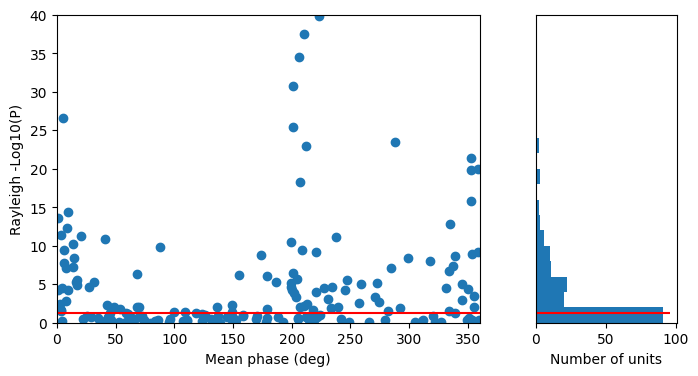

In [24]:
SIG_THRESH = 0.0001
MIN_SPKS = 100    
MAX_Y = 40

# find units with significant scores
sig_units = np.where((rayleigh_p<SIG_THRESH) & (num_spks>=MIN_SPKS))[0]

print(sig_units)
print(rayleigh_p[sig_units])
print(mean_angle[sig_units])


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]})

# Plot the scatter plot on the first subplot
axes[0].scatter(np.rad2deg(mean_angle+np.pi), -np.log10(rayleigh_p))
axes[0].hlines(-np.log10(0.05), 0, 360, "r")
axes[0].set_xlabel('Mean phase (deg)')
axes[0].set_ylabel('Rayleigh -Log10(P)')
axes[0].set_xlim(0,360)

# Plot the histogram of y-values on the second subplot
binned_vals = axes[1].hist(-np.log10(rayleigh_p), orientation='horizontal', range=(0,MAX_Y), bins=20)
axes[1].hlines(-np.log10(0.05), 0, np.max(binned_vals[0])+5, "r")
axes[1].set_xlabel('Number of units')
axes[1].set_yticks([])

axes[0].set_ylim(0,MAX_Y)
axes[1].set_ylim(0,MAX_Y)


plt.tight_layout

plt.savefig("/workspaces/human_hippocampus/dev/other/tj/figs/slice2_seizure_pvals.svg")
print("Figure saved")

# Show the figure
plt.show()




/tmp/ipykernel_853/3262579917.py:26: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for unit in sd.neuron_data[0].values():
/tmp/ipykernel_853/3262579917.py:152: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[2800.   647.5]
1.8578756501972473e-09
-0.10964893055959499
181
Figure saved


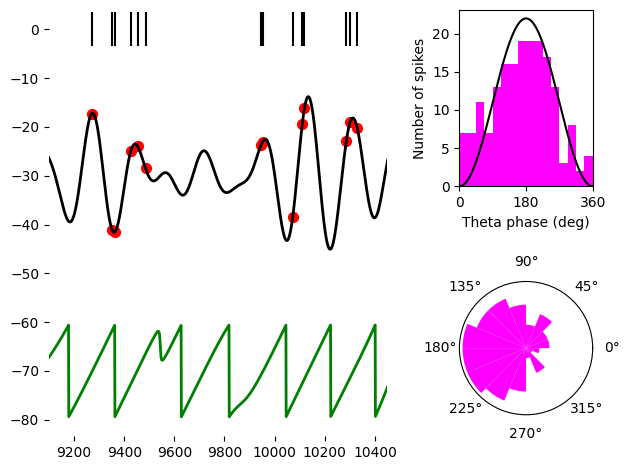

[2922.5  822.5]
2.948836538593955e-27
-3.057309549546396
430
Figure saved


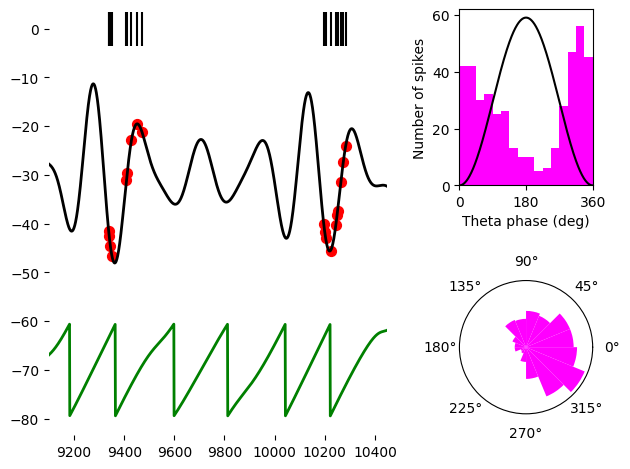

In [12]:
# # # MAIN FIGURE FOR SINGLE UNIT EXAMPLES # # #

UNITS_OI =  [9, 17] # [101,107] #  
SB_OI = 1
NBINS = 16
COLS = ["magenta", "magenta", "mediumturquoise", "magenta", "magenta", "magenta", "magenta"]

# select superburst time
sb = S_SB_TIMES[SB_OI]


# load LFP data
with open("/workspaces/" + LFP_PATH + "/seizure/acid1_start{}s_stop{}s_fs1ms.pkl".format(sb[0], sb[1]), 'rb') as filename:
    data_raw = pickle.load(filename)

# filter LFP data into individual theta frequency band
theta_filt = butter_filter(data_raw["data"], 4, 8, fs=data_raw["frame_rate"])

# obtain electrode coordinates
elec_xy = data_raw["xy"].copy()
elec_xy[:,1] = data_raw["xy"][:,0]/12.5
elec_xy[:,0] = data_raw["xy"][:,1]

# obtain unit locations
unit_xy = []
for unit in sd.neuron_data[0].values():
    unit_xy.append([unit['position'][0], unit['position'][1]] )
unit_xy = np.array(unit_xy)

# find NUM_CLOSEST closest electrodes to each unit
closest_elecs = find_k_closest_rows(unit_xy, elec_xy, NUM_CLOSEST)

# for each unit
for i, unit in enumerate(UNITS_OI):

    print(unit_xy[unit,:])
    print(rayleigh_p[unit])
    print(mean_angle[unit])
    print(len(all_spk_angles[unit]))

    # get spike times from sd
    spk_times= np.unique(np.round(sd.train[unit]).astype(int))

    # get all spike times in superburst
    all_spk_time_sb = spk_times[(spk_times > sb[0]*1000) & (spk_times < sb[1]*1000)]


    # average the theta LFP over the closest electrodes
    av_nearby_theta = np.mean(theta_filt[closest_elecs[unit,:], :], axis=0)
    av_raw_sig = np.mean(data_raw["data"][closest_elecs[unit,:], :], axis=0)

    # compute the envelope and phase angles of the averaged theta
    nearby_theta_hilbert = hilbert(av_nearby_theta)
    sig_env = np.abs(nearby_theta_hilbert)
    nearby_angles = np.angle(nearby_theta_hilbert)

    # compute sig_env RMS
    sig_env_rms = np.sqrt(np.mean(sig_env**2))

    # obtain all peaks above sig_env RMS
    detected_peaks, _ = find_peaks(av_nearby_theta, height=sig_env_rms*RMS_MULT)
    all_troughs, _ = find_peaks(-av_nearby_theta)

    # initiate empty result array
    all_spk_time_sb_above_thresh = []

    # for each detected peak
    for peak in detected_peaks:

        # find the trouhgs on each side of the peak
        pre_trough, post_trough = find_closest_values(all_troughs, peak)

        if pre_trough == None:
            pre_trough = 0
        if post_trough == None:
            post_trough = len(av_nearby_theta)

        # detect spike times within range
        cycle_spk_times = spk_times[(spk_times > sb[0]*1000+pre_trough) & (spk_times < sb[0]*1000+post_trough)]

        all_spk_time_sb_above_thresh = np.append(all_spk_time_sb_above_thresh, cycle_spk_times)

    all_spk_time_sb_above_thresh = np.int64(all_spk_time_sb_above_thresh)

    # Create a figure with a constrained layout
    fig = plt.figure(constrained_layout=True)

    # Define the GridSpec with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 3, figure=fig)

    # Create the first subplot spanning rows 1 and 2, and columns 1 and 2
    ax1 = fig.add_subplot(gs[:, :2])

    # plot average signal
    # ax1.plot(range(len(av_raw_sig)), av_raw_sig-np.mean(av_raw_sig), "k", linewidth=2)
    ax1.scatter(all_spk_time_sb_above_thresh-sb[0]*1000, np.zeros_like(all_spk_time_sb_above_thresh), marker='|', c="k", s=600)
    
    ax1.plot(range(len(av_nearby_theta)), 3*av_nearby_theta-30, "k", linewidth=2)
    # ax1.plot(range(len(sig_env)), 3*sig_env-30, "r", linewidth=2)
    # ax1.plot(range(len(sig_env)), 3*sig_env_rms*np.ones_like(sig_env)-30, "y--", linewidth=2)

    ax1.scatter(all_spk_time_sb_above_thresh-sb[0]*1000, 3*av_nearby_theta[all_spk_time_sb_above_thresh-sb[0]*1000]-30, s=50, c="r")

    ax1.plot(range(len(nearby_angles)), nearby_angles*3-70, "g", linewidth=2)

    # ax1.set_xlim(7000,9000)
    ax1.set_xlim(9100,10450)
    # ax1.set_yticks([])
    # ax1.set_xticks([])

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)




    # Create the second subplot spanning row 1 of the last column
    ax2 = fig.add_subplot(gs[0, 2])
    
    # convert radian values to degrees
    all_degree = np.rad2deg(all_spk_angles[unit])+180

    # Plot the histogram of degree values
    binned_vals = ax2.hist(all_degree, bins=NBINS, range=(0,360), alpha=1, color=COLS[i])

    # Overlay with a single oscillation
    bin_centers = range(361)
    oscillation = -np.cos(np.deg2rad(bin_centers))
    ax2.plot(bin_centers, (oscillation+1) * (np.max(binned_vals[0])+3) / 2, color='k')

    ax2.set_xlim(0,360)
    ax2.set_xticks([0,180,360])
    ax2.set_xlabel("Theta phase (deg)")
    ax2.set_ylabel("Number of spikes")



    # Create the third subplot spanning row 2 of the last column
    ax3 = fig.add_subplot(gs[1, 2], polar=True)
    
    # bin the radian values
    counts, bin_edges = np.histogram(all_spk_angles[unit]+np.pi, bins=NBINS, range=(0, 2*np.pi))
    bin_centers = bin_edges[:-1] + 0.5*np.diff(bin_edges)

    # plot bin results as a barplot on polar axis
    ax3.bar(bin_centers, counts, color=COLS[i], width=np.diff(bin_edges), bottom=0.0)
    ax3.grid(visible=False)
    ax3.set_yticks([])

    plt.tight_layout()
    

    plt.savefig("/workspaces/human_hippocampus/dev/other/tj/figs/phase_lock_example_slice2_unit{}.svg".format(unit))
    print("Figure saved")

    plt.show()




/tmp/ipykernel_629/2470184484.py:23: RuntimeWarning: invalid value encountered in cast
  axes[0].plot(range(np.int32(np.ceil(np.max([np.max(-np.log10(rayleigh_p_s)), np.max(-np.log10(rayleigh_p_ns))])))),
/tmp/ipykernel_629/2470184484.py:24: RuntimeWarning: invalid value encountered in cast
  range(np.int32(np.ceil(np.max([np.max(-np.log10(rayleigh_p_s)), np.max(-np.log10(rayleigh_p_ns))])))), "b--", linewidth=1)


Figure saved


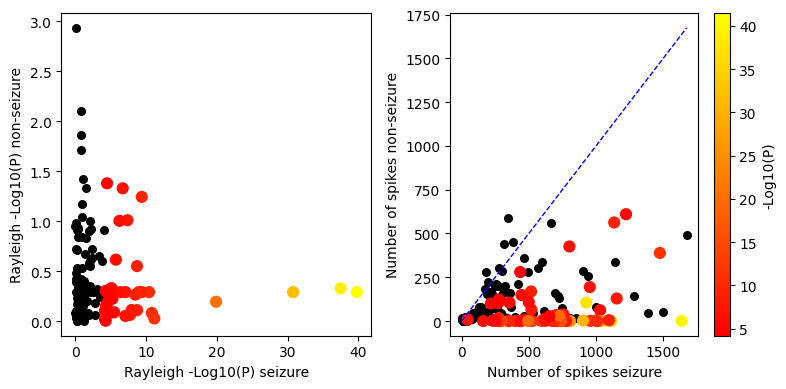

In [11]:
SIG_THRESH = 0.0001

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# # Plot the scatter plot on the first subplot
# # axes[0].scatter(np.rad2deg(mean_angle_s+np.pi), np.rad2deg(mean_angle_ns+np.pi))
# axes[0].scatter(np.rad2deg(mean_angle_s[rayleigh_p_s>SIG_THRESH]+np.pi), np.rad2deg(mean_angle_ns[rayleigh_p_s>SIG_THRESH]+np.pi), s=30, c="k")
# axes[0].scatter(np.rad2deg(mean_angle_s[rayleigh_p_s<=SIG_THRESH]+np.pi), np.rad2deg(mean_angle_ns[rayleigh_p_s<=SIG_THRESH]+np.pi), s=60, 
#                     c=-np.log10(rayleigh_p_s[rayleigh_p_s<=SIG_THRESH]), cmap="autumn")
# axes[0].plot(range(360), range(360), "b--", linewidth=1)

# axes[0].set_xlabel('Mean phase seizure (deg)')
# axes[0].set_ylabel('Mean phase non-seizure (deg)')
# axes[0].set_xlim(0,360)
# axes[0].set_ylim(0,360)

# Plot the histogram of y-values on the second subplot
# axes[1].scatter(-np.log10(rayleigh_p_s), -np.log10(rayleigh_p_ns))
axes[0].scatter(-np.log10(rayleigh_p_s[rayleigh_p_s>SIG_THRESH]), -np.log10(rayleigh_p_ns[rayleigh_p_s>SIG_THRESH]), s=30, c="k")
axes[0].scatter(-np.log10(rayleigh_p_s[rayleigh_p_s<=SIG_THRESH]), -np.log10(rayleigh_p_ns[rayleigh_p_s<=SIG_THRESH]), s=60, 
                    c=-np.log10(rayleigh_p_s[rayleigh_p_s<=SIG_THRESH]), cmap="autumn")
axes[0].plot(range(np.int32(np.ceil(np.max([np.max(-np.log10(rayleigh_p_s)), np.max(-np.log10(rayleigh_p_ns))])))), 
             range(np.int32(np.ceil(np.max([np.max(-np.log10(rayleigh_p_s)), np.max(-np.log10(rayleigh_p_ns))])))), "b--", linewidth=1)

axes[0].set_xlabel('Rayleigh -Log10(P) seizure')
axes[0].set_ylabel('Rayleigh -Log10(P) non-seizure')

# axes[1].set_xlim(0,13)
# axes[1].set_ylim(0,13)


# Plot the third subplot
axes[1].scatter(total_num_spks_s[rayleigh_p_s>SIG_THRESH], total_num_spks_ns[rayleigh_p_s>SIG_THRESH], s=30, c="k")
s = axes[1].scatter(total_num_spks_s[rayleigh_p_s<=SIG_THRESH], total_num_spks_ns[rayleigh_p_s<=SIG_THRESH], s=60, 
                    c=-np.log10(rayleigh_p_s[rayleigh_p_s<=SIG_THRESH]), cmap="autumn")
axes[1].plot(range(np.int32(np.ceil(np.max([np.max(total_num_spks_s), np.max(total_num_spks_ns)])))), 
             range(np.int32(np.ceil(np.max([np.max(total_num_spks_s), np.max(total_num_spks_ns)])))), "b--", linewidth=1)

axes[1].set_xlabel('Number of spikes seizure')
axes[1].set_ylabel('Number of spikes non-seizure')
# axes[2].set_ylim(0,1200)
# axes[2].set_xlim(0,1200)

fig.colorbar(s, ax=axes[1], label='-Log10(P)')

plt.tight_layout()

plt.savefig("/workspaces/human_hippocampus/dev/other/tj/figs/slice2_seizure_vs_nonseizure.svg")
print("Figure saved")

loading saved results


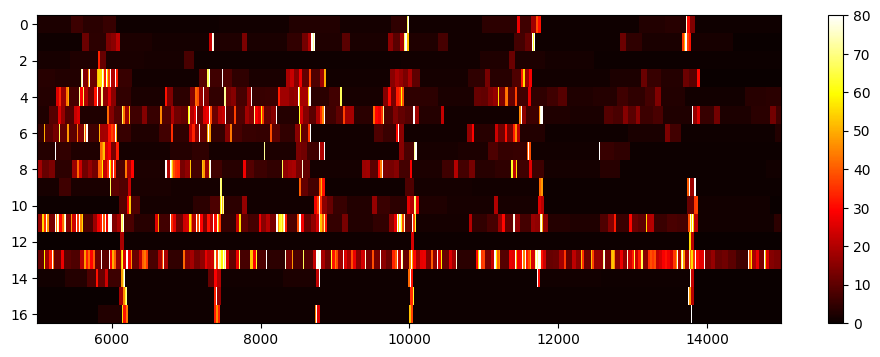

In [30]:
SIG_THRESH = 0.0001
SB_OI = 0

sb = S_SB_TIMES[SB_OI]

# define data save path given parameters
data_save_path = "/workspaces/human_hippocampus/dev/other/tj/processed_data/2023-12-03-e-Hc112823_avv9hckcr1_acid1_spike_rate_data_recomp_start{}s_stop{}s_maxlag{}.pkl".format(sb[0], sb[1], 50)

# if results already exist
if os.path.exists(data_save_path):
        
    print("loading saved results")

    # load data
    with open(data_save_path, 'rb') as f:
        data = pickle.load(f)
        rate_mat = data["isi_rate"]

sig_units = np.where([rayleigh_p<=SIG_THRESH])[1]
sig_angles = mean_angle[sig_units]

# Combine the arrays into tuples and sort based on the first element
sorted_tuples = sorted(zip(sig_angles, sig_units), key=lambda x: x)

# Separate the arrays again
sig_angles_sorted, sig_units_sorted = zip(*sorted_tuples)

rate_mat_sig_ordered = rate_mat[np.flip(sig_units_sorted), :]

# Create a figure
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

plt.imshow(rate_mat_sig_ordered, cmap='hot', interpolation='nearest', aspect='auto', vmin=0, vmax=80)
plt.colorbar()
plt.xlim(5000,15000)
plt.show()


# # Create a figure
# fig, axes = plt.subplots(1, 1, figsize=(12, 4))

# # for each sig unit in order
# for i, su in enumerate(sig_units_sorted):

#     # get spike times from sd
#     spk_times= np.unique(np.round(sd.train[su]).astype(int))

#     axes[0].scatter(spk_times, -i*np.ones_like(spk_times), c="k", marker="|")

# # plt.xlim(sb[0]*1000, sb[1]*1000)
# axes[0].xlim(14000,23000)
